In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint
from itertools import combinations


In [16]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/TP1-Gestion-de-pf/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1108:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

df_10 = df.iloc[1049:1169]
ret = df_5.values / 100
variance = np.var(ret, axis=0, keepdims=True)
std = np.sqrt(np.var(ret, axis=0, keepdims=True))

# Plage des rendements cibles
target_returns = np.linspace(-0.10, 0.10, num=100)  # Génère 100 valeurs entre -10% et 10%

rf = 0.44 / 100

# Créer la liste portfolio_names à partir des noms de colonnes, en excluant la première colonne
portfolio_names = df.columns[1:].tolist()

# Définissons la matrice de covariance et le vecteur de rendements moyens
Sigma = np.cov(ret.T)

z_barre = np.mean(ret, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
ones = np.ones((len(Z_barre))) # Vecteur de 1

# Rendement espéré du portefeuille cible
R_cible = 0.10  # Rendement espéré du portefeuille cible


In [17]:
N = 5  # Nombre total d'actifs
min_num_assets = 3
max_num_assets = 3
min_weight = 0.05  # poids minimum de 5%
target_return = 0.10
R_cible_basse = 0.01  # Rendement cible minimum de 5%
R_cible_haute = 0.10  # Rendement cible maximum de 15%

In [18]:
# Fonction objectif : Variance du portefeuille
def portfolio_variance(W,Sigma):
    return W.T @ (Sigma @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return})  # Le rendement attendu doit être égal au rendement cible

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(portfolio_variance, W, Sigma, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

Poids optimaux du portefeuille : [-9.63824458  1.83033794 15.78561241 -3.96809407 -3.0096117 ]


/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [19]:
from scipy.optimize import minimize
import numpy as np
from itertools import combinations

# Résultats initiaux
best_variance = np.inf
best_weights = None
best_combination = None

# Générer toutes les combinaisons de 3 portefeuilles parmi 5
for combination in combinations(range(N), 3):
    Sigma_sub = Sigma[np.ix_(combination, combination)]
    Z_barre_sub = Z_barre[np.array(combination)]  # Assurez-vous que Z_barre_sub est correctement défini

    initial_weights = np.ones(len(combination)) / len(combination)

    # Définissez les contraintes en utilisant Z_barre_sub
    current_constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Les poids doivent sommer à 1
        {'type': 'ineq', 'fun': lambda weights: np.dot(weights, Z_barre_sub) - R_cible_basse},
        {'type': 'ineq', 'fun': lambda weights: R_cible_haute - np.dot(weights, Z_barre_sub)}  # Utilisez np.dot ici pour la compatibilité dimensionnelle
    ]

    # Lancer l'optimisation avec Sigma_sub et Z_barre_sub
    result = minimize(portfolio_variance, initial_weights, args=(Sigma_sub,), method='trust-constr', constraints=current_constraints)

    if result.success and result.fun < best_variance:
        best_variance = result.fun
        best_weights = result.x
        best_combination = [portfolio_names[i] for i in combination]  # Mappage des indices aux noms de portefeuilles

# Affichage des résultats
if best_combination is not None:
    print("Meilleure combinaison d'actifs:", best_combination)
    print("Poids optimaux:", best_weights)
    print("Variance minimale du portefeuille:", best_variance)

Meilleure combinaison d'actifs: ['HiTec', 'Hlth ', 'Other']
Poids optimaux: [ 0.36663048  0.75562886 -0.12225933]
Variance minimale du portefeuille: 0.0023281872906225874


In [20]:
test = df_5[[best_combination[0], best_combination[1], best_combination[2]]]
test

,HiTec,Hlth,Other
Date,,,
2018-11-01,-0.93,6.42,2.81
2018-12-01,-8.23,-8.25,-10.94
2019-01-01,8.70,5.32,9.80
2019-02-01,5.39,3.30,2.96
2019-03-01,3.32,0.50,-1.47
...,...,...,...
2023-07-01,4.10,-0.11,5.24
2023-08-01,-1.58,-0.22,-3.35
2023-09-01,-5.82,-4.71,-3.41


In [21]:
ret_5 = test.values / 100
sigma_5 = np.cov(ret_5, rowvar=False)

In [22]:
z_barre = np.mean(ret_5, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Inversion de la matrice de covariance
Sigma_inv = np.linalg.inv(sigma_5)

# Construction de la matrice A et du vecteur b
A = np.array([
    [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
    [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
])
b = np.array([1, R_cible])

# Inversion de la matrice A
A_inv = np.linalg.inv(A)

# Résolution pour obtenir les multiplicateurs de Lagrange
lambda_theta = np.dot(A_inv, b)

# Calcul des poids optimaux du portefeuille
w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

print("Lambda (lambda_theta[0]) :", lambda_theta[0])
print("Theta (lambda_theta[1]) :", lambda_theta[1])
print("Poids optimaux du portefeuille :", w_optimal)

# Intervalle des rendements cibles pour la frontière efficiente
rendements_cibles_efficients = np.linspace(min(Z_barre), max(Z_barre), 100)

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []

for R_cible in rendements_cibles_efficients:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_5, wi_optimal)))
    rendements_optimaux.append(rendement_optimal)
    volatilites_optimales.append(volatilite_optimale)

# Étendre l'intervalle des rendements cibles pour la frontière complète
rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

# Calcul des volatilités et des rendements pour la frontière complète
volatilites_optimales_etendues = []
rendements_optimaux_etendus = []
for R_cible in rendements_cibles_etendus:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_5, wi_optimal)))
    rendements_optimaux_etendus.append(rendement_optimal)
    volatilites_optimales_etendues.append(volatilite_optimale)


# Risk-free rate (you need to define your risk-free rate)
rf = 0.0044

# Calculate the slope of the CML
CML_slope = (max(rendements_optimaux) - rf) / max(volatilites_optimales)

# Generate standard deviations for the CML
CML_std = np.linspace(0, max(volatilites_optimales), 100)

# Calculate corresponding expected returns for the CML
CML_ret = rf + CML_slope * CML_std

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

Lambda (lambda_theta[0]) : -0.014619239327906111
Theta (lambda_theta[1]) : 2.2594175042881672
Poids optimaux du portefeuille : [12.61311414 -7.06549132 -4.54762282]


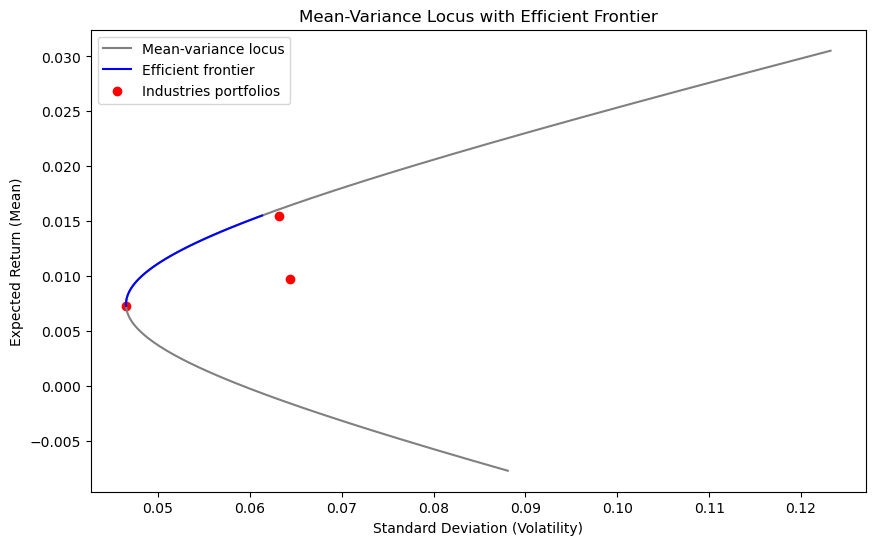

In [23]:
# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='grey')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.scatter(np.sqrt(np.diag(sigma_5)), Z_barre, color='red', label='Industries portfolios')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
#plt.grid(True)
plt.show()

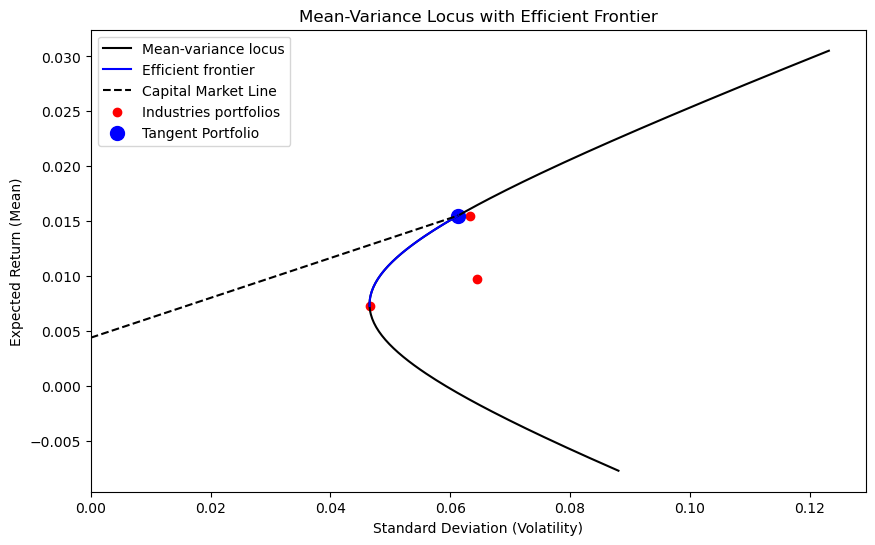

In [24]:
# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='black')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')
plt.scatter(np.sqrt(np.diag(sigma_5)), Z_barre, color='red', label='Industries portfolios')
plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.xlim(0)
plt.show()

In [25]:
# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the weights of the tangent portfolio
tangent_portfolio_weights = wi_optimal 

# Calculate the mean (expected return) of the tangent portfolio
tangent_portfolio_mean = rendements_optimaux[max_sharpe_index]

# Calculate the variance of the tangent portfolio
tangent_portfolio_variance = volatilites_optimales[max_sharpe_index] ** 2

# Print or use these values as needed
print("Tangent Portfolio Mean:", tangent_portfolio_mean)
print("Tangent Portfolio Variance:", tangent_portfolio_variance)
print("Tangent Portfolio Weights:", tangent_portfolio_weights)


Tangent Portfolio Mean: 0.015519672131147534
Tangent Portfolio Variance: 0.0037632398121613575
Tangent Portfolio Weights: [ 3.15765392 -1.02683572 -1.1308182 ]


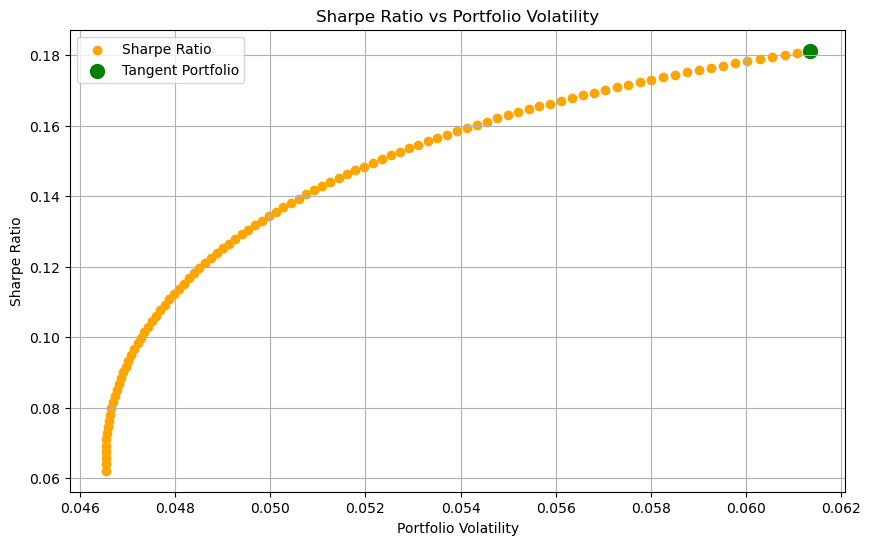

In [26]:
# Plot the Sharpe ratio against portfolio volatility
plt.figure(figsize=(10, 6))
plt.scatter(volatilites_optimales, sharpe_ratios, color='orange', label='Sharpe Ratio')

# Highlight the tangent portfolio
plt.scatter(tangent_portfolio_volatility, sharpe_ratios[max_sharpe_index], color='green', marker='o', s=100, label='Tangent Portfolio')

# Add labels and title
plt.title('Sharpe Ratio vs Portfolio Volatility')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [27]:
z_barre_5 = np.mean(ret_5, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
Sigma_5 = np.cov(ret_5.T)
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

In [28]:
# Fonction objectif : Variance du portefeuille
def minportfolio_variance(W,Sigma_5):
    return W.T @ (Sigma_5 @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma_5, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return},  # Le rendement attendu doit être égal au rendement cible
                       {'type': 'ineq', 'fun': lambda W: W})  # No short selling constraint

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma_5), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(minportfolio_variance, W, Sigma_5, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100)

# Initialiser les listes pour stocker les volatilités et rendements optimaux
volatilites_optimales = []
rendements_optimaux = []

# Itérer sur les rendements cibles pour optimiser les poids du portefeuille
for R_cible in rendements_cibles:
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
    poids_optimaux = optimize(minportfolio_variance, W, Sigma_5, R_cible)
    var_optimale = minportfolio_variance(poids_optimaux, Sigma_5)
    rendement_optimal = np.dot(poids_optimaux, Z_barre)

    volatilites_optimales.append(np.sqrt(var_optimale))
    rendements_optimaux.append(rendement_optimal)

# Calculate the CML equation
CML_returns = np.linspace(rf, max(rendements_optimaux), 100)
CML_volatilities = (CML_returns - rf) / ((max(rendements_optimaux) - rf) / max(volatilites_optimales))

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]
#tangent_portfolio_volatility = volatilites_optimales[99]

/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


Poids optimaux du portefeuille : [ 1.00249478e+00 -6.94855312e-04 -4.89264465e-04]


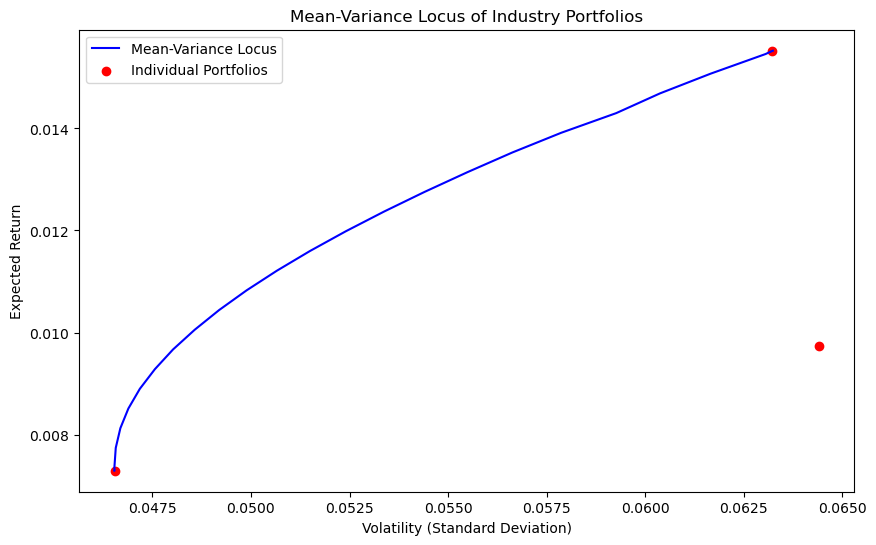

In [29]:
# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
#plt.grid(True)

(0.0, 0.06762573590248361)

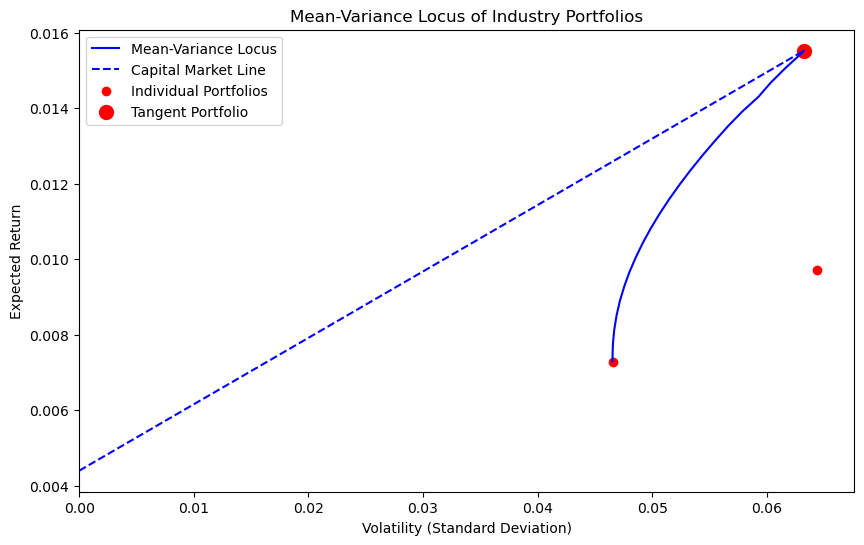

In [30]:
# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.plot(CML_volatilities, CML_returns, 'b--', label='Capital Market Line')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.scatter(volatilites_optimales[99], tangent_portfolio_return, color='red', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
#plt.grid(True)
plt.xlim(0)

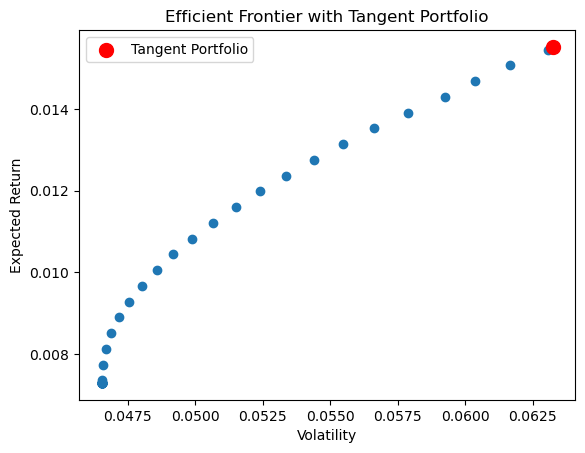

In [31]:
# Plot the efficient frontier
plt.scatter(volatilites_optimales, rendements_optimaux, marker='o', linestyle='-')

# Plot the tangent portfolio point
plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='red', marker='o', s=100, label='Tangent Portfolio')

# Add labels and title
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Tangent Portfolio')
plt.legend()

# Show the plot
plt.show()
